In [1]:
from proj_utils import *
import os, struct
import matplotlib as plt
from array import array as pyarray
import pandas as pd
from openpyxl import load_workbook
from pylab import *
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path = os.path.join(os.path.curdir, 'data')
x_train, y_train = load_NMNIST('training', digits=[0,1,2], path=path)
x_test, y_test = load_NMNIST('testing', digits=[0,1,2], path=path)

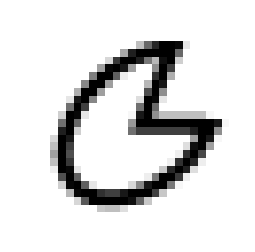

In [3]:
vectortoimg(x_train[1])

Checking multiple training vectors by plotting images.
Be patient:


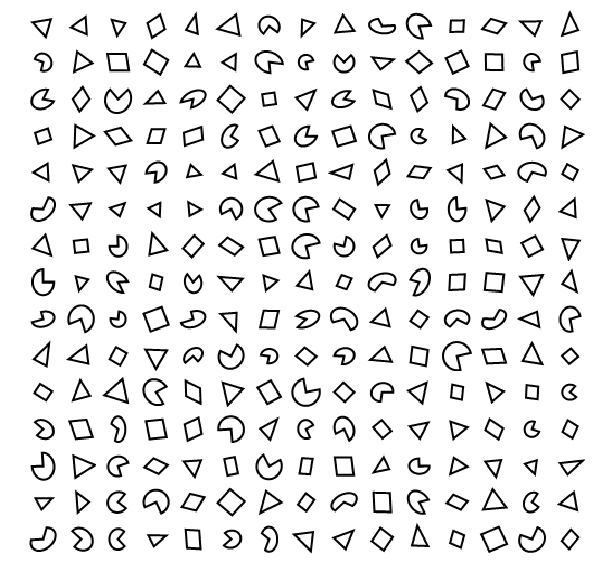

In [4]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure(figsize=(10,10))
nrows=15
ncols=15
for row in range(nrows):
    for col in range(ncols):
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        v = x_train[np.random.randint(len(x_train))]
        plt.imshow(v.reshape(28, 28),interpolation='None', cmap='gray')
        plt.axis('off')
plt.show()

In [5]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((60000, 28, 28), (60000, 1), (10000, 28, 28), (10000, 1))


## KMeans

In [6]:
from  sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [7]:
x_train_2d = np.reshape(x_train, (len(x_train), 28*28*1))
x_test_2d = np.reshape(x_test, (len(x_test), 28*28*1))

In [8]:
def kmeans(train, test):
    estimator = KMeans(n_clusters=3, n_jobs=20)
    return estimator.fit(train).predict(test)
def kmeans_pca(train, test):
    pca = PCA(n_components=3).fit(train)
    estimator = KMeans(init=pca.components_, n_clusters=3, n_init=20)
    return estimator.fit(train).predict(test)

In [9]:
%%timeit
_ = kmeans(x_train_2d, x_test_2d)

1 loop, best of 3: 12.1 s per loop


In [10]:
print(labeled_cluster_accuracy(y_test, kmeans(x_train_2d, x_test_2d)))

0.4994


# KMeans with PCA

In [11]:
%%timeit
_ = kmeans_pca(x_train_2d, x_test_2d)

/usr/local/lib/python2.7/dist-packages/sklearn/cluster/k_means_.py:893: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=20
  return_n_iter=True)


1 loop, best of 3: 6.53 s per loop


In [12]:
print(labeled_cluster_accuracy(y_test, kmeans_pca(x_train_2d, x_test_2d)))

0.4995


# AUTOENCODERS

In [13]:
#hyper-parameters
EPOCH=500
BATCH_SIZE=256

## single fully-connected neural layer as encoder and as decoder

In [37]:
# this is the size of our encoded representations
encoding_dim = 128  # 3 floats -> 3 floats represents 3 classes

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## Let's also create a separate encoder model

In [38]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## decoder model

In [39]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

## Use Crossentropy loss, and Adadelta Optimizer

In [40]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [41]:
x_train_autoencoder = x_train.astype('float32') / 255.
x_test_autoencoder = x_test.astype('float32') / 255.
x_train_autoencoder = x_train_autoencoder.reshape((len(x_train), np.prod(x_train_autoencoder.shape[1:])))
x_test_autoencoder = x_test_autoencoder.reshape((len(x_test), np.prod(x_test_autoencoder.shape[1:])))
print(x_train_autoencoder.shape)
print(x_test_autoencoder.shape)

(60000, 784)
(10000, 784)


In [42]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

## Train

In [43]:
simple_model_cp_name = 'weights.best.simple_model.hdf5'
autoencoder.fit(x_train_autoencoder, x_train_autoencoder,
                epochs=EPOCH,
                batch_size=BATCH_SIZE,
                shuffle=True,
                callbacks=[ModelCheckpoint(simple_model_cp_name, monitor='val_loss', verbose=1, save_best_only=True),
                           ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)],
                validation_data=(x_test_autoencoder, x_test_autoencoder))

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.3376 - val_loss: 0.2744
Epoch 2/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.2740 - val_loss: 0.2283
Epoch 3/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2533 - val_loss: 0.2100
Epoch 4/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2400 - val_loss: 0.1987
Epoch 5/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.2254 - val_loss: 0.1860
Epoch 6/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.2107 - val_loss: 0.1743
Epoch 7/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.1970 - val_loss: 0.1631
Epoch 8/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.1847 - val_loss: 0.1535
Epoch 9/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.1741 - val_loss: 0.1454
Epoc

Epoch 31/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.1082 - val_loss: 0.0982
Epoch 32/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.1073 - val_loss: 0.0974
Epoch 33/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.1065 - val_loss: 0.0974
Epoch 34/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.1057 - val_loss: 0.0967
Epoch 35/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.1050 - val_loss: 0.0966
Epoch 36/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.1043 - val_loss: 0.0960
Epoch 37/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.1036 - val_loss: 0.0956
Epoch 38/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.1030 - val_loss: 0.0951
Epoch 39/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.1024 - val_loss: 0.0951
Epoch 40/500
60000/60000 [====================

Epoch 62/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0938 - val_loss: 0.0909
Epoch 63/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0936 - val_loss: 0.0909
Epoch 64/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0933 - val_loss: 0.0907
Epoch 65/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0931 - val_loss: 0.0907
Epoch 66/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0929 - val_loss: 0.0905
Epoch 67/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0927 - val_loss: 0.0905
Epoch 68/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0924 - val_loss: 0.0903
Epoch 69/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0922 - val_loss: 0.0903
Epoch 70/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0920 - val_loss: 0.0903
Epoch 71/500
60000/60000 [====================

60000/60000 [==============================] - 1s 8us/step - loss: 0.0883 - val_loss: 0.0889
Epoch 95/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0882 - val_loss: 0.0890
Epoch 96/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0881 - val_loss: 0.0891
Epoch 97/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0880 - val_loss: 0.0889
Epoch 98/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0879 - val_loss: 0.0890
Epoch 99/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0878 - val_loss: 0.0889
Epoch 100/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0877 - val_loss: 0.0888
Epoch 101/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0876 - val_loss: 0.0887
Epoch 102/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0875 - val_loss: 0.0888
Epoch 103/500
60000/60000 [=============================

Epoch 130/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0858 - val_loss: 0.0885
Epoch 131/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0858 - val_loss: 0.0885
Epoch 132/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0858 - val_loss: 0.0885
Epoch 133/500
57344/60000 [===========================>..] - ETA: 0s - loss: 0.0858Epoch 00133: val_loss did not improve

Epoch 00133: reducing learning rate to 0.0625.
60000/60000 [==============================] - 1s 9us/step - loss: 0.0858 - val_loss: 0.0885
Epoch 134/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 135/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 136/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 137/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_lo

Epoch 167/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 168/500
53760/60000 [=========================>....] - ETA: 0s - loss: 0.0857Epoch 00168: val_loss did not improve

Epoch 00168: reducing learning rate to 0.00048828125.
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 169/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 170/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 171/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 172/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 173/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0857Epoch 00173: val_loss did not improve

Epoch 00173: reducing learning rate to 0.000244140625.
60000/60000 [======

Epoch 204/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 205/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 206/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 207/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 208/500
53504/60000 [=========================>....] - ETA: 0s - loss: 0.0857Epoch 00208: val_loss did not improve

Epoch 00208: reducing learning rate to 1.90734863281e-06.
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 209/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 210/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 211/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.08

60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 241/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 242/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 243/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0857Epoch 00243: val_loss did not improve

Epoch 00243: reducing learning rate to 1.49011611938e-08.
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 244/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 245/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 246/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 247/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss:

Epoch 277/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 278/500
53760/60000 [=========================>....] - ETA: 0s - loss: 0.0857Epoch 00278: val_loss did not improve

Epoch 00278: reducing learning rate to 1.16415321827e-10.
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 279/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 280/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 281/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 282/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 283/500
53760/60000 [=========================>....] - ETA: 0s - loss: 0.0857Epoch 00283: val_loss did not improve

Epoch 00283: reducing learning rate to 5.82076609135e-11.
60000/60000 

54016/60000 [==========================>...] - ETA: 0s - loss: 0.0857Epoch 00313: val_loss did not improve

Epoch 00313: reducing learning rate to 9.09494701773e-13.
60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 314/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 315/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 316/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 317/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 318/500
54528/60000 [==========================>...] - ETA: 0s - loss: 0.0857Epoch 00318: val_loss did not improve

Epoch 00318: reducing learning rate to 4.54747350886e-13.
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 319/500
60000/60000 [=============

60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 350/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 351/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 352/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 353/500
54528/60000 [==========================>...] - ETA: 0s - loss: 0.0857Epoch 00353: val_loss did not improve

Epoch 00353: reducing learning rate to 3.5527136788e-15.
60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 354/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 355/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 356/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.0857 - val_loss: 

Epoch 386/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 387/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 388/500
53760/60000 [=========================>....] - ETA: 0s - loss: 0.0858Epoch 00388: val_loss did not improve

Epoch 00388: reducing learning rate to 2.77555756156e-17.
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 389/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 390/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 391/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 392/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 393/500
54016/60000 [==========================>...] - ETA: 0s - loss: 0.0857Ep

60000/60000 [==============================] - 1s 9us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 423/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0857Epoch 00423: val_loss did not improve

Epoch 00423: reducing learning rate to 2.16840434497e-19.
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 424/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 425/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 426/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 427/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 428/500
54272/60000 [==========================>...] - ETA: 0s - loss: 0.0857Epoch 00428: val_loss did not improve

Epoch 00428: reducing learning rate to 1.08420217249e-19.
60000/60000 [=============

Epoch 459/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 460/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 461/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 462/500
60000/60000 [==============================] - 1s 9us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 463/500
59392/60000 [============================>.] - ETA: 0s - loss: 0.0857Epoch 00463: val_loss did not improve

Epoch 00463: reducing learning rate to 8.47032947254e-22.
60000/60000 [==============================] - 1s 9us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 464/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 465/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 466/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.08

60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 496/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 497/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 498/500
59392/60000 [============================>.] - ETA: 0s - loss: 0.0857Epoch 00498: val_loss did not improve

Epoch 00498: reducing learning rate to 6.61744490042e-24.
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 499/500
60000/60000 [==============================] - 1s 8us/step - loss: 0.0857 - val_loss: 0.0885
Epoch 500/500
60000/60000 [==============================] - 0s 8us/step - loss: 0.0857 - val_loss: 0.0885


In [44]:
def eval_autoencoder(autoencoder, x_test, y_test):
    encoded_imgs = autoencoder.predict(x_test)
    decoded_imgs = autoencoder.predict(encoded_imgs)
    
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    encoded_imgs = np.reshape(encoded_imgs, (encoded_imgs.shape[0], -1))
    print("Accuracy = {}".format(labeled_cluster_accuracy(y_test, kmeans_pca(encoded_imgs, encoded_imgs))))

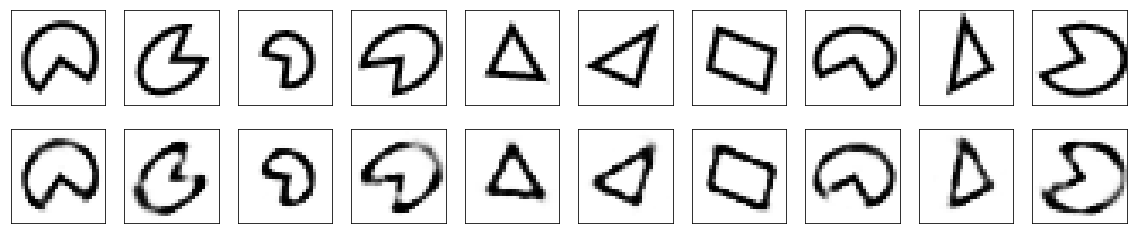

Accuracy = 0.686466666667


In [63]:
autoencoder.load_weights(simple_model_cp_name)
eval_autoencoder(autoencoder, x_train_autoencoder, y_train)

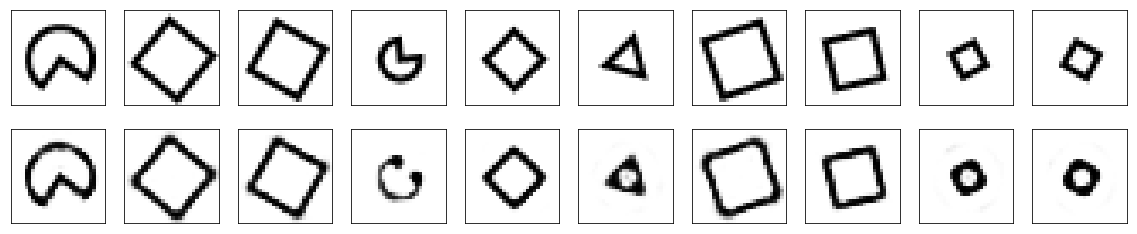

Accuracy = 0.4523


In [66]:
eval_autoencoder(autoencoder, x_test_autoencoder, y_test)

In [24]:
input_img = Input(shape=(784,))
encoded = Dense(512, activation='relu')(input_img)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

dense_model_cp_name = 'weights.best.dense_model.hdf5'
autoencoder.fit(x_train_autoencoder, x_train_autoencoder,
                epochs=EPOCH,
                batch_size=BATCH_SIZE,
                shuffle=True,
                callbacks=[ModelCheckpoint(dense_model_cp_name, monitor='val_loss', verbose=1, save_best_only=True),
                           ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)],
                validation_data=(x_test_autoencoder, x_test_autoencoder))

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 23us/step - loss: 0.3492 - val_loss: 0.2781
Epoch 2/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2861 - val_loss: 0.2590
Epoch 3/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.2707 - val_loss: 0.2474
Epoch 4/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2657 - val_loss: 0.2368
Epoch 5/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2626 - val_loss: 0.2308
Epoch 6/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.2602 - val_loss: 0.2170
Epoch 7/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2567 - val_loss: 0.2116
Epoch 8/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2513 - val_loss: 0.2087
Epoch 9/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.2461 - val_loss: 0.2

Epoch 33/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.1257 - val_loss: 0.1516
Epoch 34/500
60000/60000 [==============================] - 1s 18us/step - loss: 0.1231 - val_loss: 0.1411
Epoch 35/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.1206 - val_loss: 0.1467
Epoch 36/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.1188 - val_loss: 0.1481
Epoch 37/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.1170 - val_loss: 0.1445
Epoch 38/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.1154 - val_loss: 0.1423
Epoch 39/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.1140 - val_loss: 0.1422
Epoch 40/500
60000/60000 [==============================] - 1s 17us/step - loss: 0.1124 - val_loss: 0.1396
Epoch 41/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.1115 - val_loss: 0.1406
Epoch 42/500
60000/60000 [===========

60000/60000 [==============================] - 1s 16us/step - loss: 0.0871 - val_loss: 0.1271
Epoch 69/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0870 - val_loss: 0.1274
Epoch 70/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0870 - val_loss: 0.1281
Epoch 71/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0867 - val_loss: 0.1272
Epoch 72/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0868Epoch 00072: val_loss did not improve

Epoch 00072: reducing learning rate to 0.25.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0868 - val_loss: 0.1305
Epoch 73/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0858 - val_loss: 0.1294
Epoch 74/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0857 - val_loss: 0.1301
Epoch 75/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0856 - val_loss: 0.1306
Epoc

Epoch 105/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 106/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 107/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00107: val_loss did not improve

Epoch 00107: reducing learning rate to 0.001953125.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 108/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 109/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 110/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 111/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 112/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0849E

60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 142/500
59136/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00142: val_loss did not improve

Epoch 00142: reducing learning rate to 1.52587890625e-05.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 143/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 144/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 145/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 146/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 147/500
57088/60000 [===========================>..] - ETA: 0s - loss: 0.0849Epoch 00147: val_loss did not improve

Epoch 00147: reducing learning rate to 7.62939453125e-06.
60000/60000 [=======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00177: val_loss did not improve

Epoch 00177: reducing learning rate to 1.19209289551e-07.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 178/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 179/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 180/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 181/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 182/500
58624/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00182: val_loss did not improve

Epoch 00182: reducing learning rate to 5.96046447754e-08.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 183/500
60000/60000 [=======

Epoch 213/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 214/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 215/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 216/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 217/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00217: val_loss did not improve

Epoch 00217: reducing learning rate to 4.65661287308e-10.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 218/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 219/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 220/500
60000/60000 [==============================] - 1s 16us/step - lo

60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 250/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 251/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 252/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00252: val_loss did not improve

Epoch 00252: reducing learning rate to 3.63797880709e-12.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 253/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 254/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 255/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 256/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - v

60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 286/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 287/500
58880/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00287: val_loss did not improve

Epoch 00287: reducing learning rate to 2.84217094304e-14.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 288/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 289/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 290/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 291/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 292/500
56832/60000 [===========================>..] - ETA: 0s - loss: 0.0849Epoch 002

60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 322/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00322: val_loss did not improve

Epoch 00322: reducing learning rate to 2.22044604925e-16.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 323/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 324/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 325/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 326/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 327/500
59136/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00327: val_loss did not improve

Epoch 00327: reducing learning rate to 1.11022302463e-16.
60000/60000 [=======

59648/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00357: val_loss did not improve

Epoch 00357: reducing learning rate to 1.73472347598e-18.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 358/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 359/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 360/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 361/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 362/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00362: val_loss did not improve

Epoch 00362: reducing learning rate to 8.67361737988e-19.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 363/500
60000/60000 [=======

Epoch 393/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 394/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 395/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 396/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 397/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00397: val_loss did not improve

Epoch 00397: reducing learning rate to 6.77626357803e-21.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 398/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 399/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 400/500
60000/60000 [==============================] - 1s 16us/step - lo

60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 430/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 431/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 432/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00432: val_loss did not improve

Epoch 00432: reducing learning rate to 5.29395592034e-23.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 433/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 434/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 435/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 436/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - v

60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 466/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 467/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 00467: val_loss did not improve

Epoch 00467: reducing learning rate to 4.13590306277e-25.
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 468/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 469/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 470/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 471/500
60000/60000 [==============================] - 1s 16us/step - loss: 0.0849 - val_loss: 0.1328
Epoch 472/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0849Epoch 004

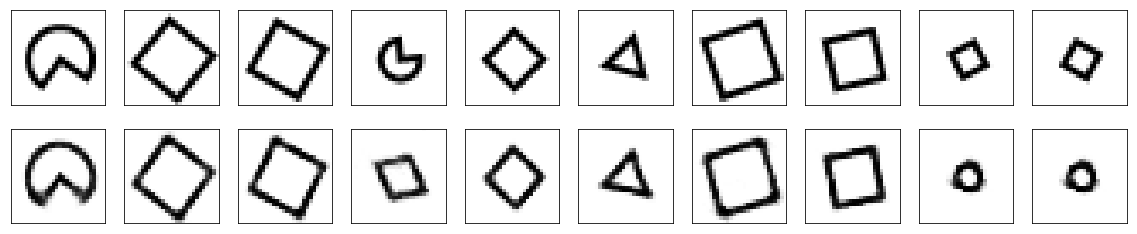

Accuracy = 0.4629


In [25]:
autoencoder.load_weights(dense_model_cp_name)
eval_autoencoder(autoencoder, x_test_autoencoder, y_test)

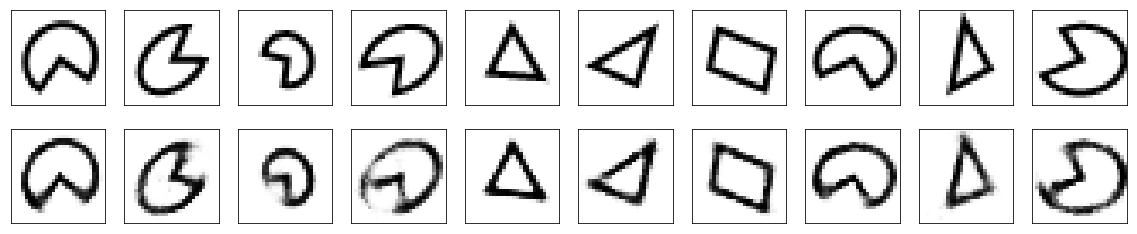

Accuracy = 0.671616666667


In [26]:
eval_autoencoder(autoencoder, x_train_autoencoder, y_train)

In [27]:
x_train_cnn = np.reshape(x_train_autoencoder, (len(x_train), 28, 28, 1)) 
x_test_cnn = np.reshape(x_test_autoencoder, (len(x_test), 28, 28, 1))

In [28]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [29]:
from keras.callbacks import TensorBoard
cnn_model_cp_name = 'weights.best.cnn_model.hdf5'
autoencoder.fit(x_train_cnn, x_train_cnn,
                epochs=EPOCH,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(x_test_cnn, x_test_cnn),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder'),
                           ModelCheckpoint(cnn_model_cp_name, monitor='val_loss', verbose=1, save_best_only=True),
                           ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 3s 48us/step - loss: 0.3666 - val_loss: 0.2963
Epoch 2/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.2822 - val_loss: 0.2065
Epoch 3/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.2375 - val_loss: 0.1917
Epoch 4/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.2115 - val_loss: 0.1697
Epoch 5/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.1962 - val_loss: 0.1682
Epoch 6/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1851 - val_loss: 0.1525
Epoch 7/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1756 - val_loss: 0.1577
Epoch 8/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1668 - val_loss: 0.1416
Epoch 9/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1595 - val_loss: 0.1

Epoch 34/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1127 - val_loss: 0.1094
Epoch 35/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1122 - val_loss: 0.1048
Epoch 36/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1115 - val_loss: 0.1082
Epoch 37/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1109 - val_loss: 0.1077
Epoch 38/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1107 - val_loss: 0.1050
Epoch 39/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1104 - val_loss: 0.1087
Epoch 40/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1100 - val_loss: 0.1038
Epoch 41/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1098 - val_loss: 0.1063
Epoch 42/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1095 - val_loss: 0.1039
Epoch 43/500
60000/60000 [===========

60000/60000 [==============================] - 2s 28us/step - loss: 0.1014 - val_loss: 0.0963
Epoch 69/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1011 - val_loss: 0.0958
Epoch 70/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1009 - val_loss: 0.0976
Epoch 71/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.1008 - val_loss: 0.0956
Epoch 72/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.1007 - val_loss: 0.0971
Epoch 73/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.1008 - val_loss: 0.0955
Epoch 74/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.1004 - val_loss: 0.0957
Epoch 75/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.1002 - val_loss: 0.0946
Epoch 76/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.1003 - val_loss: 0.0944
Epoch 77/500
60000/60000 [========================

Epoch 102/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0973 - val_loss: 0.0921
Epoch 103/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0973 - val_loss: 0.0922
Epoch 104/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0972 - val_loss: 0.0928
Epoch 105/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0971 - val_loss: 0.0920
Epoch 106/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0972 - val_loss: 0.0918
Epoch 107/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0971 - val_loss: 0.0918
Epoch 108/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0970 - val_loss: 0.0917
Epoch 109/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0970 - val_loss: 0.0919
Epoch 110/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0969 - val_loss: 0.0920
Epoch 111/500
60000/60000 [=

60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 137/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0912
Epoch 138/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0912
Epoch 139/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0960Epoch 00139: val_loss improved from 0.09114 to 0.09112, saving model to weights.best.cnn_model.hdf5

Epoch 00139: reducing learning rate to 0.015625.
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 140/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 141/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 142/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 143/500
60000/60000 [============

60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 172/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 173/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 174/500
59392/60000 [============================>.] - ETA: 0s - loss: 0.0960Epoch 00174: val_loss did not improve

Epoch 00174: reducing learning rate to 0.0001220703125.
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 175/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 176/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 177/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 178/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val

60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 208/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 209/500
59392/60000 [============================>.] - ETA: 0s - loss: 0.0960Epoch 00209: val_loss did not improve

Epoch 00209: reducing learning rate to 9.53674316406e-07.
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 210/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 211/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 212/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 213/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 214/500
59136/60000 [============================>.] - ETA: 0s - loss: 0.0959Epoch 002

60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 244/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0959Epoch 00244: val_loss did not improve

Epoch 00244: reducing learning rate to 7.45058059692e-09.
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 245/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 246/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 247/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 248/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 249/500
59392/60000 [============================>.] - ETA: 0s - loss: 0.0960Epoch 00249: val_loss did not improve

Epoch 00249: reducing learning rate to 3.72529029846e-09.
60000/60000 [=======

59648/60000 [============================>.] - ETA: 0s - loss: 0.0959Epoch 00279: val_loss did not improve

Epoch 00279: reducing learning rate to 5.82076609135e-11.
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 280/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 281/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 282/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 283/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 284/500
58880/60000 [============================>.] - ETA: 0s - loss: 0.0959Epoch 00284: val_loss did not improve

Epoch 00284: reducing learning rate to 2.91038304567e-11.
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 285/500
60000/60000 [=======

Epoch 315/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 316/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 317/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 318/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 319/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0959Epoch 00319: val_loss did not improve

Epoch 00319: reducing learning rate to 2.27373675443e-13.
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 320/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 321/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 322/500
60000/60000 [==============================] - 2s 29us/step - lo

60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 352/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 353/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 354/500
59392/60000 [============================>.] - ETA: 0s - loss: 0.0960Epoch 00354: val_loss did not improve

Epoch 00354: reducing learning rate to 1.7763568394e-15.
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 355/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 356/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 357/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 358/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - va

60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 388/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 389/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0960Epoch 00389: val_loss did not improve

Epoch 00389: reducing learning rate to 1.38777878078e-17.
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 390/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 391/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 392/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 393/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 394/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0960Epoch 003

60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 424/500
58880/60000 [============================>.] - ETA: 0s - loss: 0.0959Epoch 00424: val_loss did not improve

Epoch 00424: reducing learning rate to 1.08420217249e-19.
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 425/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 426/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 427/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 428/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 429/500
59648/60000 [============================>.] - ETA: 0s - loss: 0.0959Epoch 00429: val_loss did not improve

Epoch 00429: reducing learning rate to 5.42101086243e-20.
60000/60000 [=======

59392/60000 [============================>.] - ETA: 0s - loss: 0.0959Epoch 00459: val_loss did not improve

Epoch 00459: reducing learning rate to 8.47032947254e-22.
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 460/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 461/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 462/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 463/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 464/500
59136/60000 [============================>.] - ETA: 0s - loss: 0.0959Epoch 00464: val_loss did not improve

Epoch 00464: reducing learning rate to 4.23516473627e-22.
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 465/500
60000/60000 [=======

Epoch 495/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 496/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 497/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 498/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 499/500
59392/60000 [============================>.] - ETA: 0s - loss: 0.0959Epoch 00499: val_loss did not improve

Epoch 00499: reducing learning rate to 3.30872245021e-24.
60000/60000 [==============================] - 2s 28us/step - loss: 0.0960 - val_loss: 0.0911
Epoch 500/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0960 - val_loss: 0.0911


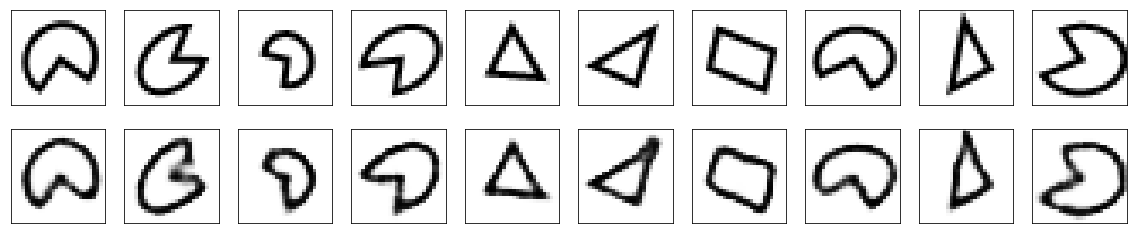

Accuracy = 0.68165


In [30]:
autoencoder.load_weights(cnn_model_cp_name)
eval_autoencoder(autoencoder, x_train_cnn, y_train)

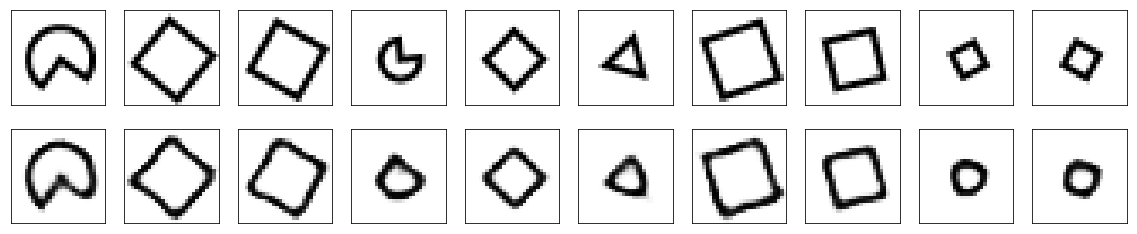

Accuracy = 0.456


In [31]:
eval_autoencoder(autoencoder, x_test_cnn, y_test)

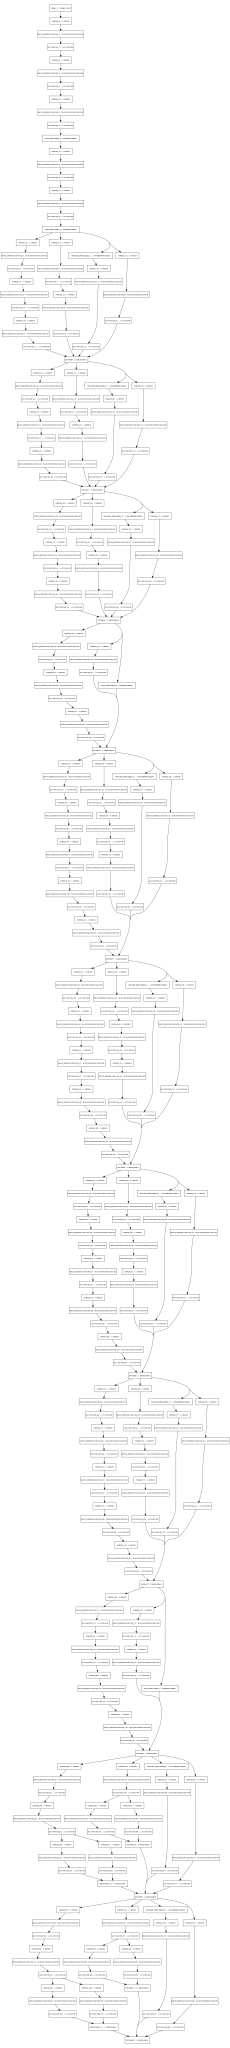

In [32]:
from IPython.display import SVG
from keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import model_to_dot
inception_model = InceptionV3(weights='imagenet', include_top=False)
SVG(model_to_dot(inception_model).create(prog='dot', format='svg'))

In [33]:
# check the layers by name
for i,layer in enumerate(inception_model.layers):
    print(i,layer.name)

(0, 'input_5')
(1, 'conv2d_8')
(2, 'batch_normalization_1')
(3, 'activation_1')
(4, 'conv2d_9')
(5, 'batch_normalization_2')
(6, 'activation_2')
(7, 'conv2d_10')
(8, 'batch_normalization_3')
(9, 'activation_3')
(10, 'max_pooling2d_4')
(11, 'conv2d_11')
(12, 'batch_normalization_4')
(13, 'activation_4')
(14, 'conv2d_12')
(15, 'batch_normalization_5')
(16, 'activation_5')
(17, 'max_pooling2d_5')
(18, 'conv2d_16')
(19, 'batch_normalization_9')
(20, 'activation_9')
(21, 'conv2d_14')
(22, 'conv2d_17')
(23, 'batch_normalization_7')
(24, 'batch_normalization_10')
(25, 'activation_7')
(26, 'activation_10')
(27, 'average_pooling2d_1')
(28, 'conv2d_13')
(29, 'conv2d_15')
(30, 'conv2d_18')
(31, 'conv2d_19')
(32, 'batch_normalization_6')
(33, 'batch_normalization_8')
(34, 'batch_normalization_11')
(35, 'batch_normalization_12')
(36, 'activation_6')
(37, 'activation_8')
(38, 'activation_11')
(39, 'activation_12')
(40, 'mixed0')
(41, 'conv2d_23')
(42, 'batch_normalization_16')
(43, 'activation_16')


In [34]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_8[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_9 (

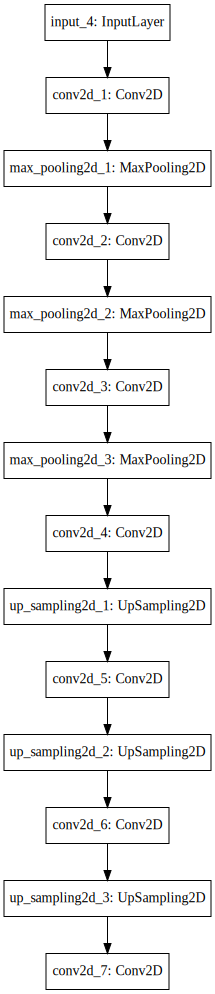

In [36]:
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))